# Predicting Electricity consumption

## Team
Dmitri Rozgonjuk <br>
Eerik Sven Puudist <br>
Triin Pohla  <br>
Andri Hõbemägi <br>

**Product Owner:** Kristjan Eljand

# Introduction
The present project was a capstone project for the Machine Learning (MTAT.03.227) course. The general aim was to predict a household's energy consumption. A major side goal of our team was to try out different modeling techniques for educational purposes.

## Our Approach
Our general approach is illustrated in Figure 1, and the steps with detailed annotation are completed throughout this notebook.
![](images/ML_project_workflow.png "Figure 1. General Project Workflow")

It is noteworthy that although the process seems to be relatively linear, this is to illustrate the general workflow from data ingestion to Kaggle submission. In reality, the process included several changes on-the-go, since we learned about new methods and techniques during the project. However, for the sake of cohesion, we display the **general** solution within the present notebook. This means that the model goodness metrics should reflect the **relative** goodness (not the metrics achieved throughout the project process). The original models which were used for actual submissions are split between different notebooks which are stored in the `x_old_files` directory. Although those notebooks had differences in some methods (e.g., how train-test split was done, which target variable was used, etc), the present notebook distills the optimal solutions found with those methods. To that end, we found it fruitful to limit the amount of data used for training (using `prophet`, the best MAE scores were obtained when training was done from May 1st 2022), doing the 80-20 train-validation split based on time (i.e., earlier time series were used as training, later/last timeseries as validation), computing the rolling averages for the target variable and using the 3-hour rolling average as the main target feature.

## 0. Setup
Importing the necessary libraries and setting other settings.

In [1]:
# Dataframes and vector ops
import numpy as np
import pandas as pd
import math

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ML modules
## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
## Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet # Prophet time-series forecasting
from skforecast.ForecasterAutoreg import ForecasterAutoreg
#import autosklearn.regression # auto-sklearn
## Metrics
from sklearn.metrics import mean_absolute_error

# MISC
import json # used for 'holidays' extraction
import requests # used for 'holidays' extraction
from copy import deepcopy
import time

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


## 1. Data Import and a Quick Glimpse
The original data set is from Kaggle, and the below code could be uncommented in order to download that data, unzip the file, and import the data tables that invlude training, test, and submissions data file. The submissions data file is a sample submission for testing that the data are submitted to Kaggle in the appropriate format.

In [2]:
# Download data from kaggle
#!kaggle competitions download -c predict-electricity-consumption

# Unzip the data
#!unzip predict-electricity-consumption.zip

In [3]:
# Import the data
df_train = pd.read_csv("data/train.csv")
# Rename 'consumption' to 'y_original'
df_train = df_train.rename(columns = {'consumption': 'y_original'})

df_test = pd.read_csv("data/test.csv")
df_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
print(f'Dimensions of training data: {df_train.shape}')
print(f'Earliest timepoint (training data): {min(df_train["time"])}')
print(f'Latest timepoint (training data): {max(df_train["time"])}')
df_train.head()

Dimensions of training data: (8592, 13)
Earliest timepoint (training data): 2021-09-01 00:00:00+03:00
Latest timepoint (training data): 2022-08-24 23:00:00+03:00


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,y_original
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


In [5]:
print(f'Dimensions of test data: {df_test.shape}')
print(f'Earliest timepoint (test data): {min(df_test["time"])}')
print(f'Latest timepoint (test data): {max(df_test["time"])}')
df_test.head()

Dimensions of test data: (168, 12)
Earliest timepoint (test data): 2022-08-25 00:00:00+03:00
Latest timepoint (test data): 2022-08-31 23:00:00+03:00


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price
0,2022-08-25 00:00:00+03:00,21.1,15.2,69.0,0.0,NaN,340.0,9.0,9.3,1022.0,2.0,0.25533
1,2022-08-25 01:00:00+03:00,20.1,15.1,73.0,0.0,NaN,30.0,6.0,14.8,1022.0,2.0,0.19492
2,2022-08-25 02:00:00+03:00,20.1,15.1,73.0,0.0,NaN,320.0,7.0,13.0,1022.0,2.0,0.18853
3,2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,NaN,0.0,4.0,11.1,1022.4,4.0,0.19947
4,2022-08-25 04:00:00+03:00,18.1,17.1,94.0,0.0,NaN,280.0,7.0,11.1,1022.0,3.0,0.21192


## 2. Data Preprocessing
In this section, we are extracting information from available data. Additionally, here is where we implement data transformations and prepare the final datasets for use in models.

### 2.1. Extracting Features from `time` Column
Before we start extracting information from the `time` variable, we first need to convert the column to a `datetime64` type in pandas. Then, we should look into the time range of each data set. The goal is to see what were the date ranges (for extracting additional features, e.g., holidays), and to see if the test data immediately follows training data in time sequence.

In [6]:
# Transform the 'time' column to a `datetime` format 
df_train['time'] = pd.to_datetime(df_train['time'], utc=True).map(lambda x: x.tz_convert('Europe/Helsinki'))
df_test['time'] = pd.to_datetime(df_test['time'], utc=True).map(lambda x: x.tz_convert('Europe/Helsinki'))
df_submission['time'] = pd.to_datetime(df_submission['time'], utc=True).map(lambda x: x.tz_convert('Europe/Helsinki'))

In [7]:
print(f"The range of training data: {df_train['time'].min(), df_train['time'].max()}")
print()
print(f"The range of test data: {df_test['time'].min(), df_test['time'].max()}")

The range of training data: (Timestamp('2021-09-01 00:00:00+0300', tz='Europe/Helsinki'), Timestamp('2022-08-24 23:00:00+0300', tz='Europe/Helsinki'))

The range of test data: (Timestamp('2022-08-25 00:00:00+0300', tz='Europe/Helsinki'), Timestamp('2022-08-31 23:00:00+0300', tz='Europe/Helsinki'))


Ok, from this we see that, indeed, the training and test data are sequential. The training dates range from 09.01.2021 to 24.08.2022, while the range for test data is 25.08.2022 until 31.08.2022. Now, we will also download the Estonian holidays table and keep only the rows for the relevant time period. (Let's also save the holidays table in case we need to use this in the future.)

In [8]:
# NOTE! Also possible to fetch the holidays info via 'holidays' Python module

# Fetch the list of holidays from 'riigipühad.ee'
r = requests.get('https://riigipühad.ee/?output=json')
json_str = json.dumps(r.json())
holidays = pd.read_json(json_str)
holidays['time'] = pd.to_datetime(holidays['date'], utc=True)
holidays['date'] = holidays['time'].dt.date

# Replace the values for holiday kind (to cat, and more readablity)
## 1 = 'Riigipüha' = '1_sthol' # state holiday
## 2 = 'Rahvuspüha' = '2_nathol' # national holiday
## 3 = 'Riiklik tähtpäev' = '3_natday' # nationally celebrated day
## 4 = 'Lühendatud tööpäev' = '4_shortday' # shortened day before holiday
holidays['kind_id'] = holidays['kind_id'].astype(str)
holidays['kind_id'] = holidays['kind_id'].str.replace('1', '1_sthol')
holidays['kind_id'] = holidays['kind_id'].str.replace('2', '2_nathol')
holidays['kind_id'] = holidays['kind_id'].str.replace('3', '3_natday')
holidays['kind_id'] = holidays['kind_id'].str.replace('4', '4_shortday')

In [9]:
holidays.rename(columns= {'kind_id':'h_type'}, inplace = True) # rename the col for later clarity
# holidays.to_csv('estonian_holidays.csv', index=False) # for saving to your local machine

# Keep only the relevant rows
holidays = holidays[(holidays['date'] >= df_train['time'].dt.date.min()) & 
                    (holidays['date'] <= df_test['time'].dt.date.max())].reset_index(drop = True)
# holidays['kind_id'].value_counts() # count the unique holiday types

# Create the mini df for merge
df_holidays = holidays.loc[:, ['date', 'h_type']]
df_holidays['is_holiday'] = np.full(len(df_holidays), 1) # 1 = is a holiday
df_holidays.head()

# might be useful for calendar data: https://towardsdatascience.com/holiday-calendars-with-pandas-9c01f1ee5fee

,date,h_type,is_holiday
0,2021-09-12,3_natday,1
1,2021-09-22,3_natday,1
2,2021-10-16,3_natday,1
3,2021-11-02,3_natday,1
4,2021-11-14,3_natday,1


Below, we are creating a helper function that extracts information from the timestamp feature.

In [10]:
### 2.1. Create meaningful variables from 'time'
def wrangle_dates(df_original):
    """A function that turns a pd.Series datetime column to several more granular columns
    Args:
        df (pandas DataFrame): input data (e.g., df_train or df_test)
    """
    df = deepcopy(df_original)
    
    # Date variables
    df['date'] = df['time'].dt.date # date
    df['year'] = df['time'].dt.year # year
    df['month'] = df['time'].dt.month # month
    df['month_name'] = df['time'].dt.month_name() # month
    df['dow'] = df['time'].dt.dayofweek # day-of-week
    df['dayname'] = df['time'].dt.day_name() # dayname
    df['weekend'] = 0 # not weekend

    # update weekend column values if it's a weekend day
    for i in range(len(df)):
        if df['dow'][i] in [5,6]:
            df['weekend'][i] = 1 # is weekend
            
    # Time variables
    ## Only the 'hour' varies, hence no need for 'time' and 'minute'
    df['hour'] = df['time'].dt.hour.astype(int) # hour
    
    # Season
    conditions = [
        (df['month'].isin(np.arange(3,6))), (df['month'].isin(np.arange(6,9))), 
        (df['month'].isin(np.arange(9,12))), (df['month'].isin(np.arange(1,3))), (df['month'] == 12)]
    choices = ['Spring','Summer', 'Autumn', 'Winter', 'Winter']
    df['season'] = np.select(conditions, choices)
    
    # Drop numeric day-of-week, month variables
    df = df.drop(columns = ['dow', 'month'], axis = 1)
    
    # Can optionally drop the `time` variable here
    #df = df.drop(columns = ['time'], axis = 1)
    return df

Apply the funciton `wrangle_dates()` to both training and test data and make some other preprocessing steps (impute the missing feature values,  etc).

In [11]:
df_train = wrangle_dates(df_train)

# Add holidays info
df_train = df_train.merge(df_holidays, on = 'date', how = 'left')
df_train['h_type'] = df_train['h_type'].fillna('not_hol').astype(str)
df_train['is_holiday'] = df_train['is_holiday'].fillna(0).astype(int)

# Custom fill for `snow` (fill with the next non-NaN value)
snow = df_train['snow'].to_numpy()
snow_index = df_train.index[~df_train['snow'].isna()].tolist()
current_snow_value = 0
for i in range(len(snow)):
    if i > 5241:
        current_snow_value = 0
        snow[i] = current_snow_value
    if i not in (snow_index):
        snow[i] = current_snow_value
    if i in (snow_index):
        current_snow_value = snow[i]
        snow[i] = current_snow_value
df_train['snow'] = snow

# Fill `prcp` with 0
df_train['prcp'] = df_train['prcp'].fillna(0.0)

# Fill NAs with last valid values, convert `coco` to categorical
df_train['coco'].fillna(method = 'ffill', inplace = True)
df_train['coco'] = df_train['coco'].astype(str)

# Remove 'date', as it's redundant
df_train = df_train.drop(columns = ['date'])

df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,el_price,y_original,year,month_name,dayname,weekend,hour,season,h_type,is_holiday
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,0.09016,0.577,2021,September,Wednesday,0,0,Autumn,not_hol,0
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,0.09251,0.594,2021,September,Wednesday,0,1,Autumn,not_hol,0
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,0.08890,0.685,2021,September,Wednesday,0,2,Autumn,not_hol,0
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,0.08735,1.016,2021,September,Wednesday,0,3,Autumn,not_hol,0
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,0.08688,0.677,2021,September,Wednesday,0,4,Autumn,not_hol,0


The same preprocessing for test data set.

In [12]:
df_test = wrangle_dates(df_test)

# Add holidays info
df_test = df_test.merge(df_holidays, on = 'date', how = 'left')
df_test['h_type'] = df_test['h_type'].fillna('not_hol').astype(str)
df_test['is_holiday'] = df_test['is_holiday'].fillna(0).astype(int)

# Fill `snow` with 0 (no snow in August)
df_test['snow'] = df_test['snow'].fillna(0.0)

# Fill `prcp` with 0
df_test['prcp'] = df_test['prcp'].fillna(0.0)
df_test.head()

# Fill NAs with last valid values, convert `coco` to categorical
df_test['coco'].fillna(method = 'ffill', inplace = True)
df_test['coco'] = df_test['coco'].astype(str)

# Remove 'date', as it's redundant
df_test = df_test.drop(columns = ['date'])

df_test.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,year,month_name,dayname,weekend,hour,season,h_type,is_holiday
0,2022-08-25 00:00:00+03:00,21.1,15.2,69.0,0.0,0.0,340.0,9.0,9.3,1022.0,2.0,0.25533,2022,August,Thursday,0,0,Summer,not_hol,0
1,2022-08-25 01:00:00+03:00,20.1,15.1,73.0,0.0,0.0,30.0,6.0,14.8,1022.0,2.0,0.19492,2022,August,Thursday,0,1,Summer,not_hol,0
2,2022-08-25 02:00:00+03:00,20.1,15.1,73.0,0.0,0.0,320.0,7.0,13.0,1022.0,2.0,0.18853,2022,August,Thursday,0,2,Summer,not_hol,0
3,2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,0.0,0.0,4.0,11.1,1022.4,4.0,0.19947,2022,August,Thursday,0,3,Summer,not_hol,0
4,2022-08-25 04:00:00+03:00,18.1,17.1,94.0,0.0,0.0,280.0,7.0,11.1,1022.0,3.0,0.21192,2022,August,Thursday,0,4,Summer,not_hol,0


## 2.1. `consumption` transformations
This is our target variable. Here, we first impute the few missing data points by using interpolation - in essence, this is the value of average of the previous and next time point. In order to avoid a zero when doing the log-normalization later, we also add a tiny constant to all values (to avoid zeros).

In [13]:
# Fill the NAs with the average of previous and next value in time-series
df_train['y_imp'] = df_train['y_original'].interpolate()

# Add a constant to avoid '0.0'
df_train['y_imp'] = df_train['y_imp'] + 0.0000000000001

We should also try to smooth our data a bit - using moving averages could be useful here. To that end, let's explore some potential autocorrelation values of target feature and, based on that, adjust the values with a N-day moving average. 

First, let's compute a vector of autocorrelations. This should help us with selecting how many shifts (i.e., the N hours) would be reasonable for predictions.

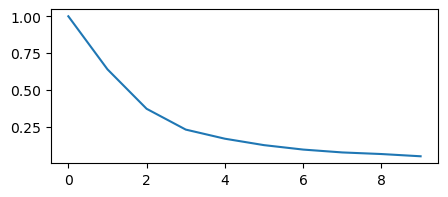

In [14]:
autocors = [df_train['y_imp'].autocorr(i) for i in range(10)]

plt.figure(figsize=[5,2])
plt.plot(autocors)
plt.show();

The figure above shows that perhaps it makes sense to compute the rolling averages up to three hours the most, as after that the autocorrelations get quite low.

In [15]:
# Compute new values: rolling means over 2 and 3 days
## Fill the NAs of N rows (N = size of rolling window) with the original values
df_train['y_imp_r2'] = df_train['y_imp'].rolling(2).mean()
nan_idx = df_train[df_train['y_imp_r2'].isnull()].index
df_train.loc[nan_idx.values, 'y_imp_r2'] = df_train.loc[nan_idx.values, 'y_imp_r2'].fillna(df_train.loc[nan_idx.values, 'y_imp'])

df_train['y_imp_r3'] = df_train['y_imp'].rolling(3).mean()
nan_idx = df_train[df_train['y_imp_r3'].isnull()].index
df_train.loc[nan_idx.values, 'y_imp_r3'] = df_train.loc[nan_idx.values, 'y_imp_r3'].fillna(df_train.loc[nan_idx.values, 'y_imp'])

df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,month_name,dayname,weekend,hour,season,h_type,is_holiday,y_imp,y_imp_r2,y_imp_r3
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,September,Wednesday,0,0,Autumn,not_hol,0,0.577,0.5770,0.577000
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,September,Wednesday,0,1,Autumn,not_hol,0,0.594,0.5855,0.594000
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,September,Wednesday,0,2,Autumn,not_hol,0,0.685,0.6395,0.618667
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,September,Wednesday,0,3,Autumn,not_hol,0,1.016,0.8505,0.765000
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,September,Wednesday,0,4,Autumn,not_hol,0,0.677,0.8465,0.792667


Let's take a look at the different rolling means values:

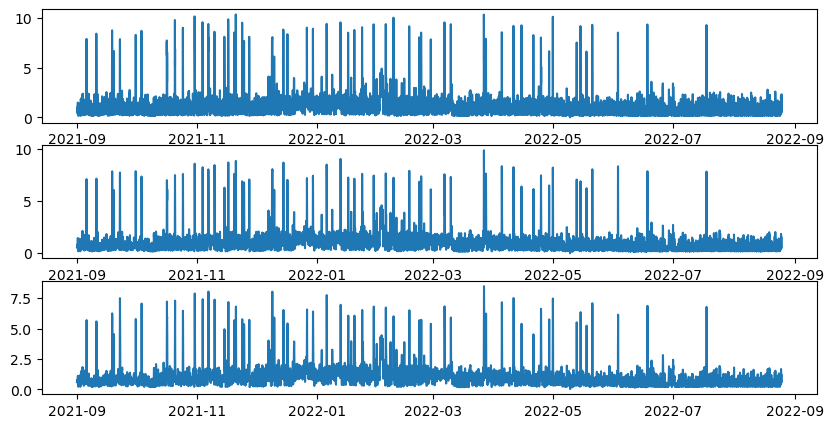

In [16]:
fig, (ax1, ax2, ax3,
     ) = plt.subplots(nrows = 3,
                      ncols = 1, figsize = [10, 5])
ax1.plot(df_train['time'], df_train['y_imp'])
ax2.plot(df_train['time'], df_train['y_imp_r2'])
ax3.plot(df_train['time'], df_train['y_imp_r3'])

plt.show();

There is still some significant intra-day variation that results in spikes in the graphs. Let's try to further smooth these spikes by applying log-normalization. Let's then plot the results. Note: when predicting the values, make sure to exponentiate the predictions!

In [17]:
df_train['y_imp_log'] = np.log(df_train['y_imp'])
df_train['y_imp_r2_log'] =  np.log(df_train['y_imp_r2'])
df_train['y_imp_r3_log'] = np.log(df_train['y_imp_r3'])
df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,hour,season,h_type,is_holiday,y_imp,y_imp_r2,y_imp_r3,y_imp_log,y_imp_r2_log,y_imp_r3_log
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,0,Autumn,not_hol,0,0.577,0.5770,0.577000,-0.549913,-0.549913,-0.549913
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,1,Autumn,not_hol,0,0.594,0.5855,0.594000,-0.520876,-0.535289,-0.520876
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,2,Autumn,not_hol,0,0.685,0.6395,0.618667,-0.378336,-0.447069,-0.480189
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,3,Autumn,not_hol,0,1.016,0.8505,0.765000,0.015873,-0.161931,-0.267879
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,4,Autumn,not_hol,0,0.677,0.8465,0.792667,-0.390084,-0.166645,-0.232352


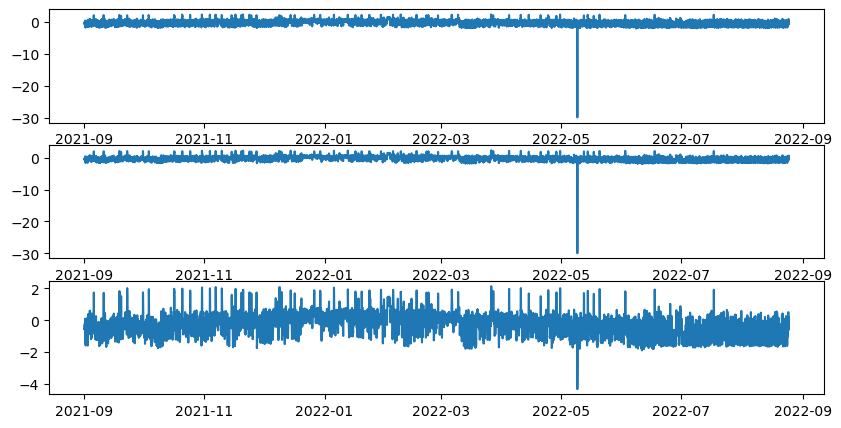

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, 
                      ncols = 1, figsize = [10, 5])
ax1.plot(df_train['time'], df_train['y_imp_log'])
ax2.plot(df_train['time'], df_train['y_imp_r2_log'])
ax3.plot(df_train['time'], df_train['y_imp_r3_log'])
plt.show();

Right, now we see that graphs are smoother - with the exception of a spike sometime in May. This is likely because on a particular timepoint, the consumption was zero. Could be a power outage. We'll keep this presently as is but we acknowledge that it may be reasonable to apply additional transformations (e.g., average this, etc).

## Preparing the Training, Validation, and Test Data
Here, we split the initial training data to training and validation sets. We also keep the test data separately.

In [19]:
# Extract all y-variables (including the augmented/transformed ones) - NB! There are several y-variables!
y_features = df_train.filter(regex='y_')

# Prepare the X-data
X = df_train.drop(columns = df_train.filter(regex='y_'))
X =  X.drop(columns = ['time'])

# Find the split time index (1st May 2022)
split_idx = X[(X['month_name'] == 'May') & (X['year'] == 2022) &  (X['hour'] == 0)].index[0]
X = X[split_idx:].reset_index(drop = True)
y_features = y_features[split_idx:].reset_index(drop = True)
y = y_features['y_imp_r3'] # Extract the three-hour moving average imputed y

# Test data
X_test = df_test.drop(columns = ['time'])

In [20]:
# Train-validation split
split_index = math.ceil(len(X) * 0.8) # 80%-20% split

train_X = X[:split_index].reset_index(drop = True)
val_X = X[split_index:].reset_index(drop = True)
train_y = y[:split_index].reset_index(drop = True)
val_y = y[split_index:].reset_index(drop = True)

len(train_X), len(val_X)

(2228, 556)

### Feature pre-processing
The cell below includes the feature preprocessing. We use the `MinMaxScaler()` to scale the numerical features, while One-Hot-Encoding OHE) is used for caterical features. The former is first fitted on the training split and then, subsequently, the transformations are made based on that fit. The OHE is done with training, validation, and test set combined, since this would ensure the existence of all categories in all datasets.

In [21]:
# Collect lists of variable names based on type for subsequent use
num_vars = []
cat_vars = []
int_vars = []
for i in range(len(train_X.dtypes)):
    if train_X.dtypes.values[i] == 'float64':
        num_vars.append(train_X.dtypes.index[i])
    elif train_X.dtypes.values[i] == 'object':
        cat_vars.append(train_X.dtypes.index[i])
    elif train_X.dtypes.values[i] == 'int64':
        int_vars.append(train_X.dtypes.index[i])

# Scale the float variables
scaler = MinMaxScaler()

# Fit on the training set
scaler.fit(train_X[num_vars])
# Transform the features of other data sets (fit based on training ste)
train_X[num_vars] = scaler.transform(train_X[num_vars])
val_X[num_vars] = scaler.transform(val_X[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

# One-hot encoding for categorical vars
## Should be done for train + val + test in one df because otherwise N of vars not the same
ohe_vars = pd.get_dummies(pd.concat([train_X[cat_vars], 
                                     val_X[cat_vars],
                                     X_test[cat_vars]
                                    ], 
                                    ignore_index=True))
ohe_vars = pd.get_dummies(pd.concat([train_X[cat_vars], val_X[cat_vars], X_test[cat_vars]], ignore_index=True))

# Drop the old categorical features
train_X = train_X.drop(columns = cat_vars)
val_X = val_X.drop(columns = cat_vars)
X_test = X_test.drop(columns = cat_vars)

# Add the OHE variables to train, test, and val data
## lengths of datasets for index-based extraction
len_xtrain = len(train_X)
len_xval = len(val_X)
len_xtest = len(X_test)

# Add the OHE vars to training, validation, and test sets instead of the previous categorical vars
train_X = train_X.join(ohe_vars[:len_xtrain])
val_X = val_X.join(ohe_vars[len_xtrain:(len_xtrain + len_xval)].reset_index(drop = True))
X_test = X_test.join(ohe_vars[(len_xtrain + len_xval):].reset_index(drop = True))

print(f'Training data dims, X: {train_X.shape,}, y = {train_y.shape}.')
print(f'Validation data dims, X: {val_X.shape,}, y = {val_y.shape}.')
print(f'Test data dims, X: {val_X.shape,}.')

Training data dims, X: ((2228, 43),), y = (2228,).
Validation data dims, X: ((556, 43),), y = (556,).
Test data dims, X: ((556, 43),).


# Modeling
In this section, we are running the models we used for predictions throughout the duration of this project. Of note, most of the modeling was performed in other notebooks - we refer the reader to look into them for more details. 

Because we adapted our approaches, data preprocessing, and modeling throughout the project time, the notebooks - although using largely similar approaches - have variations that result in differences between solutions below. For instance, there may have been variations in data cleaning, target variable use (i.e., using original,or imputed, or a moving average-based, or log-normalized values), training-validation data splits, etc. We duly acknowledge that the present notebooks serves as a general summary of our workflow, and that some differences in model performance rely on differences in methods from the present notebook. However, we also want to stress that when working with these mdoels, we discovered that the general *relative* goodness of models against each other remains roughly in the same order.

Below, we are presenting variations of the better solutions tom illustrate our workflow outlined in Figure 1.

As mentioned above, we found, in general, that the best models are obtained when we use the three-day moving average (`y_imp_r3`) as the target variable. During trying out different models and timeframes, we discovered that the models with data from May 1st 2022 onward performed well (as opposed to using all available data from the apst). Finally, though alternative solutions are present, the meaningful way to train the models would be by using trian-validation data splits based on time, i.e., validation data should be later in time than training data.

In general, we used three approached: (a) algorithms that do not model time-series (predicting the traget from features), (b) algorithms/frameworks designed for time-series forecasts (forecasting the target from a sequence of itself), and (c) ensemble predictions of the best of two approaches (averaging the predictions of the best models' predictions). 

Before we start modeling, we create a data table that would store the name, runtime, and MAE of each model. Additionally, a dataframe that includes an array for every model's predictions is created (in LR code cell) and updated. This would allow later for a simple ensembling.

In [22]:
# Initialize a df where the model performance will be collected
df_models = pd.DataFrame(columns = ['model', 'runtime', 'MAE'])
df_models.head()

,model,runtime,MAE


## Non-Time-Series Based Approaches
In the present section, we tried using the mdoeling approach which is not taking into account the nature of the data (which is time-series). To that end, we used the training-validation data splits (see above) made on the Kaggle training data where last observations were predicted from the first ones. 

Here, we have regression-based algorithms (Linear Regression, Lasso, Ridge, Elastic Net), as well as tree-based (Decision Tree) and ensemble (Random Forest, XGBoost) algorithms. Finally, out of curiosity, we also used the `auto-sklearn` module to see if completely automated, hands-off solution is fruitful. (It should be noted that this approach was not fruitful in Kaggle, one might need to run it in Google Colab, and we are demonstrating it with a realtively limited amount of training time).

### Regressions
#### Linear Regression

In [23]:
lambda_ = 1 # provide a lambda value

start = time.time()
lr = LinearRegression()
lr.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict_LR = lr.predict(val_X)
mae = mean_absolute_error(val_y, predict_LR)
print(f'MAE: {mae}')

# Append to models df
df_models = df_models.append({'model': 'LR', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Another df for model predictions
df_preds = pd.DataFrame({'LR': predict_LR})

MAE: 0.31954576312699356


#### Lasso Regression

In [24]:
start = time.time()
lr_lasso = Lasso(lambda_)
lr_lasso.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict_LASSO = lr_lasso.predict(val_X)
mae = mean_absolute_error(val_y, predict_LASSO)
print(f'MAE: {mae}')

# Append to models df
df_models = df_models.append({'model': 'LASSO', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
df_preds['LASSO'] = predict_LASSO

MAE: 0.277727790628636


#### Ridge Regression

In [25]:
start = time.time()
lr_ridge = Ridge(lambda_)
lr_ridge.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict_RIDGE = lr_ridge.predict(val_X)
mae = mean_absolute_error(val_y, predict_RIDGE)
print(f'MAE: {mae}')

# Append to models df
df_models = df_models.append({'model': 'RIDGE', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
df_preds['RIDGE'] = predict_RIDGE

MAE: 0.28843628314592157


#### Elastic Net Regression

In [26]:
start = time.time()
lr_elastic = ElasticNet(alpha = lambda_)
lr_elastic.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict_ElasticNet = lr_elastic.predict(val_X)
mae = mean_absolute_error(val_y, predict_ElasticNet)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'ElasticNet', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
df_preds['ElasticNet'] = predict_ElasticNet

MAE: 0.2509215909038105


### Intermediate Summary: Regressions
Below we are displaying the model MAEs with model runtimes for the regression models:

In [27]:
df_models.sort_values('MAE', ascending = True).reset_index(drop = True)

,model,runtime,MAE
0,ElasticNet,0.002850,0.250922
1,LASSO,0.003952,0.277728
2,RIDGE,0.004953,0.288436
3,LR,0.006814,0.319546


Here, Elastic Net Regression seems to perform the best.

### Decision Tree
We also tried the decision tree regressor. After fitting a baseline, i.e., not tuned model, we used grid search for tuning the hyperparameters. This resulted in the below-outlined model:

In [28]:
start = time.time()
tuned_dt = DecisionTreeRegressor(max_depth=6,
                                 max_features='auto',
                                 max_leaf_nodes=20,
                                 min_samples_leaf=3,
                                 min_weight_fraction_leaf=0.1,
                                 splitter='random', 
                                random_state=0)
tuned_dt.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict_DT = tuned_dt.predict(val_X)
mae = mean_absolute_error(val_y, predict_DT)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'Tuned DT', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
df_preds['Tuned DT'] = predict_DT

MAE: 0.24506364901985161


### Random Forest

In [29]:
start = time.time()
tuned_rf = RandomForestRegressor(n_estimators = 950, 
                                 bootstrap = False, 
                                 max_depth = None, 
                                 max_features = 'sqrt', 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2,
                                random_state= 0)

tuned_rf.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict_RF = tuned_rf.predict(val_X)
mae = mean_absolute_error(val_y, predict_RF)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'Tuned RF', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
df_preds['Tuned RF'] = predict_RF

MAE: 0.22201337687744543


### XGBoost

In [30]:
start = time.time()
xgb_best = xgb.XGBRegressor(colsample_bytree = 0.9, 
                                 learning_rate = 0.01, 
                                 max_depth = 10, 
                                 n_estimators = 400, seed=0)
xgb_best.fit(train_X, train_y)
runtime = time.time() - start

# Predictions
predict_XGBoost = xgb_best.predict(val_X)
mae = mean_absolute_error(val_y, predict_XGBoost)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'XGBoost', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
df_preds['XGBoost'] = predict_XGBoost

MAE: 0.21909084500967058


### Automated Machine Learning with `auto-sklearn`
Here, we try out how an ensemble from a five-minute automated model training fares off with our other approaches.

In [31]:
# import autosklearn.regression
#start = time.time()
#automl = autosklearn.regression.AutoSklearnRegressor(
#    time_left_for_this_task= 60*5) # search pipeline for 5 minutes
#automl.fit(train_X, train_y)
#runtime = time.time() - start

# Predictions
#predict_automl = automl.predict(val_X)
#mae = mean_absolute_error(val_y, predict_automl)
#print(f'MAE: {mae}')

#df_models = df_models.append({'model': 'auto-sklearn', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
#df_preds['auto-sklearn'] = predict_automl

### Intermediate summary

In [32]:
df_models.sort_values('MAE').reset_index(drop = True)

,model,runtime,MAE
0,XGBoost,1.545996,0.219091
1,Tuned RF,3.473371,0.222013
2,Tuned DT,0.003442,0.245064
3,ElasticNet,0.002850,0.250922
4,LASSO,0.003952,0.277728
5,RIDGE,0.004953,0.288436
6,LR,0.006814,0.319546


## Time-Series Based Approaches
In this section, we switch to time-series based forecasting. To that end, we try out two frameworks: the `prophet` library and `skforecast`. Both take the taraget variable as the input (therefore, other fetaures are ignored completely). Additionally, `prophet` takes the timestamps as input. As mentioned above, we are using the 3-hour moving averages as the target variable.

### Prophet
First, data needs to be converted into the specific format.

In [33]:
df_ts = df_train[['time', 'y_imp_r3']] # timeseries df
df_prophet = df_ts[split_idx:].reset_index(drop = True) # use the split index starting from May 1, 2022
df_prophet = df_prophet.rename(columns = {'time':'ds', 'y_imp_r3':'y'})
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

Then, the forecasting can be applied.

In [34]:
start = time.time()
m = Prophet(changepoint_prior_scale=0.01).fit(df_prophet)
future = m.make_future_dataframe(periods=168, freq='H')
fcst = m.predict(future)
runtime = time.time() - start

# fig = m.plot(fcst) # Possibility to display the forecast figure
# fcst.head() # uncomment to see how the forecasting output df looks like

prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmpd4oxmscb/0mbrr_ep.json
cmdstanpy  DEBUG input tempfile: /var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmpd4oxmscb/lpq0ifn9.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/drdr/opt/anaconda3/envs/ml_2022/lib/python3.7/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25037', 'data', 'file=/var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmpd4oxmscb/0mbrr_ep.json', 'init=/var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmpd4oxmscb/lpq0ifn9.json', 'output', 'file=/var/folders/28/mdvjx70j6qqfykv1xw8gz1n00000gn/T/tmpd4oxmscb/prophet_modelq9381o2t/prophet_model-20221211154829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:29 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain 

Let's find the predictions for the timeframe that was also used for other models and compute the MAE.

In [35]:
predict_Prophet = fcst.iloc[len(train_X):len(train_X)+len(val_X)].reset_index(drop = True)['yhat']

mae = mean_absolute_error(val_y, predict_Prophet)

print(f'MAE: {mae}')
df_models = df_models.append({'model': 'Prophet', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
df_preds['Prophet'] = predict_Prophet

# Extract the predictions for test data (Kaggle)
# predictions = fcst.iloc[-168:][['ds', 'yhat']].reset_index(drop = True)
# predictions.head()

MAE: 0.2166286217409674


## skforecast approach: RandomForest

In [36]:
start = time.time()
skforecast_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators=1000),
                lags      = 20
             )

skforecast_RF.fit(y= y)
runtime = time.time() - start

# Predictions
predict_skforecast_RF = xgb_best.predict(val_X)
mae = mean_absolute_error(val_y, predict_skforecast_RF)
print(f'MAE: {mae}')

df_models = df_models.append({'model': 'skforecast RF', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

# Add the predictions
df_preds['skforecast RF'] = predict_skforecast_RF

MAE: 0.21909084500967058


## XGBoost Time-Series approach

## Ensembling the TOP Models

In [37]:
# Display the top models
top_models = df_models.sort_values('MAE')[:3].reset_index(drop = True)
top_models.head()

,model,runtime,MAE
0,Prophet,0.773607,0.216629
1,XGBoost,1.545996,0.219091
2,skforecast RF,26.852066,0.219091


In [38]:
# Compute the average of top model predictions
df_preds['TOP_ensemble'] = np.mean(df_preds[top_models['model']], axis = 1)

# Test the average against the validation data
mae = mean_absolute_error(val_y, df_preds['TOP_ensemble'])
print(f'MAE: {mae}')

# Sum the runtime of individual regressors for the ensemble
runtime = top_models['runtime'].sum()

df_models = df_models.append({'model': 'TOP Ensemble', 'MAE': mae, 'runtime':runtime}, ignore_index = True)

MAE: 0.20339550083931857


## Final Performance Results
Below are the results of model performances in a tabular format, and as a scatter plot where we show the potential association between model runtime and goodness of predictions. Although the data set for the rpesent project was for one household, modelling thousands or hundreds of thousands of households may increase the demand in resources needed for computation. Hence, the plot could be useful for decision-making when one needs to consider the runtime-accurayc tradeoff.

In [39]:
df_models = df_models.sort_values('MAE').reset_index(drop = True)
df_models

,model,runtime,MAE
0,TOP Ensemble,29.171669,0.203396
1,Prophet,0.773607,0.216629
2,XGBoost,1.545996,0.219091
3,skforecast RF,26.852066,0.219091
4,Tuned RF,3.473371,0.222013
5,Tuned DT,0.003442,0.245064
6,ElasticNet,0.002850,0.250922
7,LASSO,0.003952,0.277728
8,RIDGE,0.004953,0.288436
9,LR,0.006814,0.319546


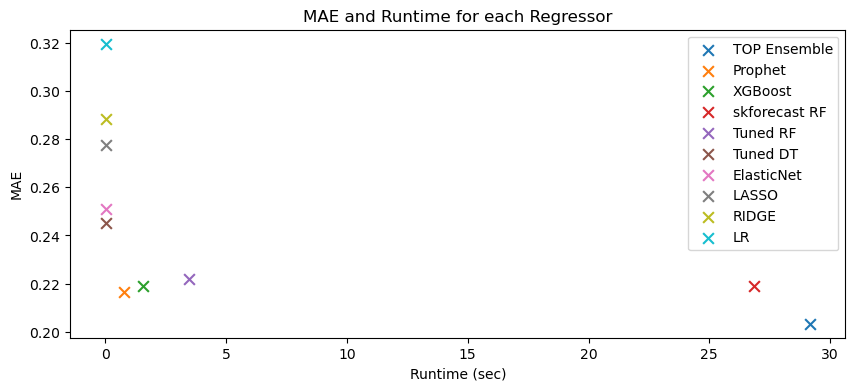

In [40]:
plt.figure(figsize = [10, 4])

for i in range(len(df_models)):

    plt.scatter(df_models['runtime'][i], 
            df_models['MAE'][i], 
            label = df_models['model'][i],
               marker = 'x',
               s = 60)
    plt.legend()
plt.xlabel('Runtime (sec)')
plt.ylabel('MAE')
plt.title('MAE and Runtime for each Regressor')
plt.show();

# Kaggle Results

In [41]:
df_kaggle = pd.read_csv('kaggle_results.csv', sep = ';')
df_kaggle

,Model,Specifics,Score,ScoreLabel
0,LR,LR,0.44184,PublicScore
1,LR,LR (May),0.35440,PublicScore
2,Ridge,Ridge,0.40911,PublicScore
3,Ridge,Ridge (May),0.33932,PublicScore
4,DT,DecisionTree,1.33609,PublicScore
5,DT,DecisionTree (May),0.36449,PublicScore
6,RF,RF,0.64259,PublicScore
7,RF,RF (May),0.40432,PublicScore
8,auto-sklearn,auto-sklearn (5 min),0.37109,PublicScore
9,auto-sklearn,auto-sklearn (60 min),0.36815,PublicScore


In [42]:
df_kaggle.sort_values(['Model', 'Specifics', 'ScoreLabel']).reset_index(drop = True).head()

,Model,Specifics,Score,ScoreLabel
0,DT,DecisionTree,1.72418,PrivateScore
1,DT,DecisionTree,1.33609,PublicScore
2,DT,DecisionTree (May),0.41930,PrivateScore
3,DT,DecisionTree (May),0.36449,PublicScore
4,Ensemble,"Ensamble (LR, Ridge, DT, RF)",0.41083,PrivateScore


In [43]:
img

NameError: name 'img' is not defined

# Conclusion
<font color= 'red'>
WRITE THE CONCLUSION

- What performed the best? (did the top ensemble beat the individual models?)
- Which models were the runner-ups?
- Which solution(s) received the best public scores on Kaggle?
- Which solution(s) received the best private scores on Kaggle? What could explain the difference?
    </font>